In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2

In [6]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet50(pretrained=True)
        self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
        self.encoded_channels=1024
    
    def forward(self, image):
        a = self.extractor(image)
        return {
            'early': a['layer3_conv3'],
            'middle': a['layer3_conv3'],
            'deep': a['layer3_conv3'],
        }

torch.Size([77485])


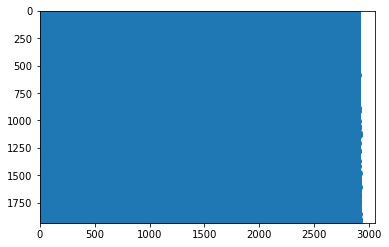

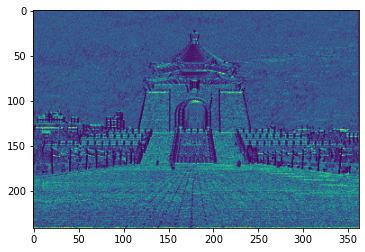

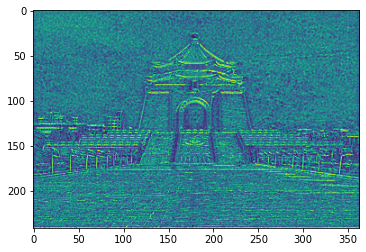

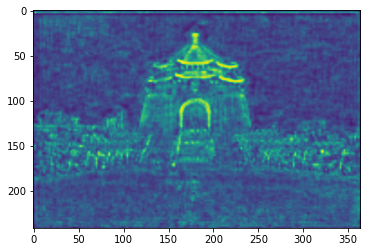

In [10]:
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/witi/Downloads/autoenc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/witi/Downloads/attention.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3)
image = Image.open('/home/witi/Downloads/test1.jpg')
image_np = np.array(image)
image = utils.preprocess_image(image_np)
image = torch.as_tensor(image)
image = torch.unsqueeze(image, 0)

keypoints, descriptors, scores, detections = extraction_model(image)

print(scores.size())

plt.imshow(image_np)
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.show()
plt.imshow(detections[0])
plt.show()
plt.imshow(detections[1])
plt.show()
plt.imshow(detections[2])

In [11]:
pair_idx = 1
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

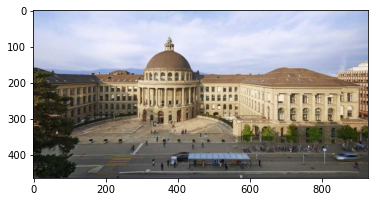

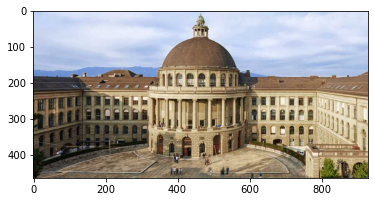

In [12]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [14]:
# encoder = DummyEncoder().eval()
# attention = attention_model.MultiAttentionLayer(encoder).eval()

# extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.0)
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/witi/Downloads/autoenc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/witi/Downloads/attention.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3, thresh=0.15)

In [22]:
print(image1.shape)

torch.Size([1, 3, 465, 930])


In [15]:
kp1, descr1, scores1, det1 = extraction_model(image1)
kp2, descr2, scores2, det2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]

print(scores1)
print(scores2)

4678 --> 4678
4371 --> 4371
tensor([0.9889, 0.9605, 0.9498,  ..., 0.1505, 0.1504, 0.1500])
tensor([0.9735, 0.9591, 0.9588,  ..., 0.1506, 0.1506, 0.1501])


In [16]:
matches = match_descriptors(descr1, descr2, cross_check=True)
n_matches = len(matches)
print(len(matches))

1120


In [17]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
print(keypoints_left)
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

[[293.3032   331.04907 ]
 [595.89716  308.4493  ]
 [266.79315  206.57698 ]
 ...
 [ 32.758373 445.80978 ]
 [469.77112  233.36679 ]
 [518.82837   34.49923 ]]
Number of inliers: 7.


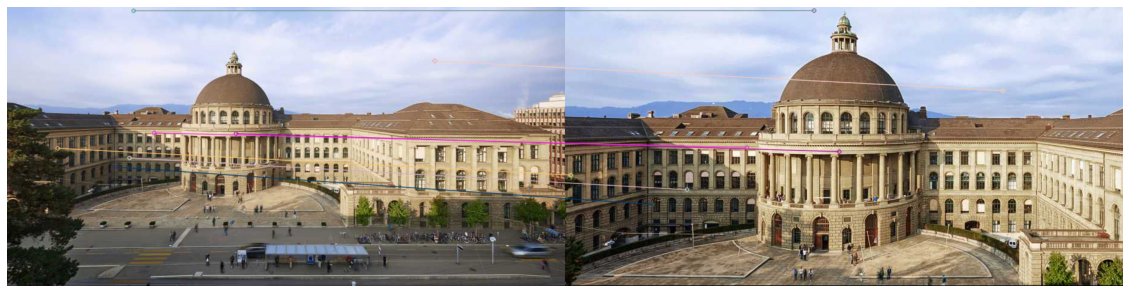

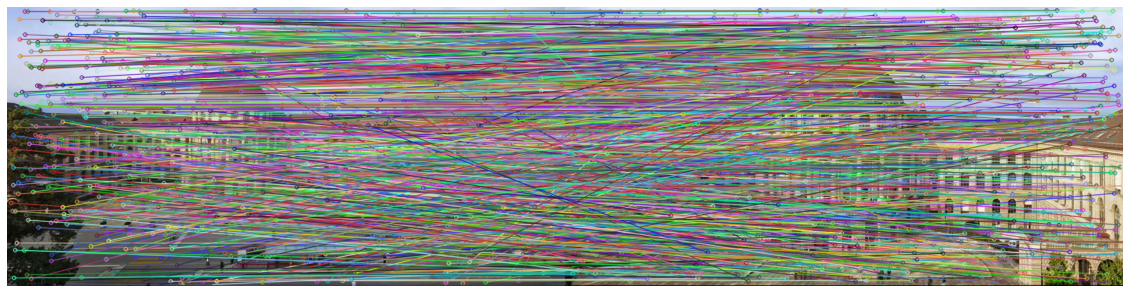

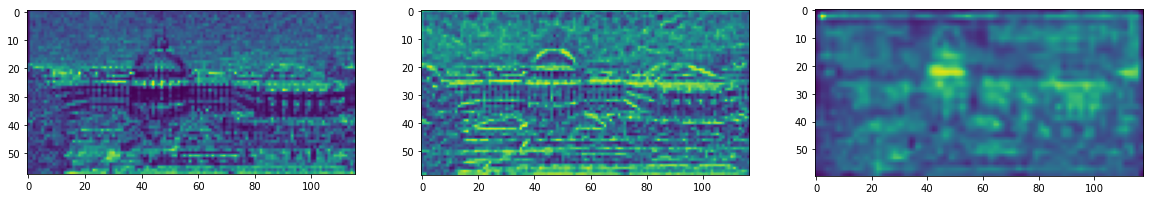

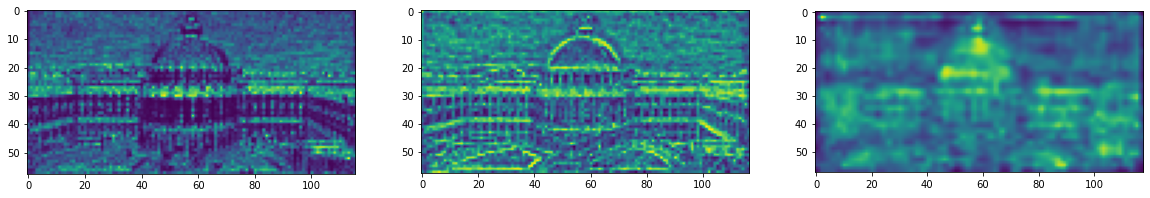

[array([[0.0384095 , 0.14539467, 0.09535148, ..., 0.09528603, 0.18262267,
        0.04729555],
       [0.0372326 , 0.18350746, 0.11426801, ..., 0.18522815, 0.1535621 ,
        0.05880533],
       [0.04377138, 0.17397775, 0.19796523, ..., 0.3174002 , 0.16789883,
        0.10026995],
       ...,
       [0.20647389, 0.20448664, 0.15265732, ..., 0.1627123 , 0.05025827,
        0.09830296],
       [0.06357189, 0.05251153, 0.07472438, ..., 0.06875791, 0.1555805 ,
        0.12044293],
       [0.09023096, 0.07696415, 0.15087216, ..., 0.07936387, 0.04048225,
        0.21812606]], dtype=float32), array([[0.8553249 , 0.42839015, 0.40858576, ..., 0.63184106, 0.4935414 ,
        0.28867874],
       [0.42968917, 0.24473652, 0.13954128, ..., 0.31698185, 0.23829222,
        0.19392316],
       [0.49926704, 0.3180615 , 0.2146642 , ..., 0.22696607, 0.24403267,
        0.21533227],
       ...,
       [0.19771864, 0.16763085, 0.33011898, ..., 0.33753553, 0.28108883,
        0.2985833 ],
       [0.22751136

In [18]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det1[0])
axs[1].imshow(det1[1])
axs[2].imshow(det1[2])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det2[0])
axs[1].imshow(det2[1])
axs[2].imshow(det2[2])
plt.show()
print(det2[:])